### Loading Libraries

In [49]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

plt.style.use('seaborn')

In [50]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [51]:
folder=os.listdir('/content/drive/My Drive/Dataset/images')
folder=[f for f in folder if not f=='.DS_Store']
print(folder)

['humans', 'horses', 'cats', 'dogs']


### Creating Data for Validation 

In [52]:
split=0.2
if not os.path.isdir('/content/drive/My Drive/Dataset/val_images'):
    os.mkdir('/content/drive/My Drive/Dataset/val_images')
    for f in folder:
        os.mkdir('/content/drive/My Drive/Dataset/val_images/'+f)
        img_names=os.listdir('/content/drive/My Drive/Dataset/images/'+f)
        to_move=int(split*len(img_names))
        img_names=img_names[:to_move]
        for name in img_names:
            src=os.path.join('/content/drive/My Drive/Dataset/images/'+f,name) #return path
            dest=os.path.join('/content/drive/My Drive/Dataset/val_images/'+f,name)
            shutil.move(src,dest)

### Data Augmentation and creating image data generator

In [53]:
train_gen=ImageDataGenerator(rescale=1.0/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True)
# Generator with Data Augmentation
val_gen = ImageDataGenerator(rescale=1.0/255) 
#Just Normalising Validation Data image as Augmentation is not needed

In [54]:
# train_gen.flow_from_directory?

In [55]:
train_generator=train_gen.flow_from_directory(
    '/content/drive/My Drive/Dataset/images/',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')
val_generator=val_gen.flow_from_directory(
    '/content/drive/My Drive/Dataset/val_images/',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

Found 648 images belonging to 4 classes.
Found 160 images belonging to 4 classes.


In [56]:
x,y=train_generator.next()
print(x.shape,y.shape) 
#y is encoded with one hot encoding

(32, 224, 224, 3) (32, 4)


### Loading pre-trained ResNet50 Neural Network

In [57]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

model=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))

In [58]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Adding custom classifier layer - Feature Extraction

In [59]:
#To built classifier part for conv Base we need to know output shape of conv base which is
# (10,10,2048). we will apply global average pooling on it and shape will now be a linear arr
# of 2048 -> GlobalAveragePooling2D takes mean accross every channel.

In [60]:
from keras.layers import *
from keras.models import Model

#creating network of layers for classifier by passing prev layer as input for current layer
layer1=GlobalAveragePooling2D()(model.output)
layer2=Dense(256,activation='relu')(layer1)
layer3=Dropout(0.5)(layer2)
output_layer = Dense(4,activation='softmax')(layer3)

In [61]:
# Grouping convBase of Resnet and custom classifier together
model=Model(inputs=model.input,outputs=output_layer) # Model groups layers into an object with training and inference features.
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

### Fine Tuning

In [62]:
print(len(model.layers))
print(model.layers)
# Making lower level portion of the network non trainable because it represents generic features
for i in range(169):
    model.layers[i].trainable=False

179
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f79ab3cdc50>, <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f79ab2f5cf8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f79ab3fde48>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f79ab2f5080>, <tensorflow.python.keras.layers.core.Activation object at 0x7f79ab2f5fd0>, <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f79ab2f5470>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f79ab3cd828>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f79ab24d0f0>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f79ab265240>, <tensorflow.python.keras.layers.core.Activation object at 0x7f79ab265dd8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f79ab26a2b0>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0

In [63]:
from keras.optimizers import Adam 
adam=Adam(lr=0.00003)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [64]:
history=model.fit(train_generator,epochs=40,steps_per_epoch = 5, validation_data = val_generator,validation_steps = 4 )

Epoch 1/40
5/5 [==============================] - 3s 674ms/step - loss: 1.6057 - accuracy: 0.2625 - val_loss: 1.5504 - val_accuracy: 0.2578
Epoch 2/40
5/5 [==============================] - 3s 529ms/step - loss: 1.4828 - accuracy: 0.2812 - val_loss: 1.4975 - val_accuracy: 0.2578
Epoch 3/40
5/5 [==============================] - 3s 535ms/step - loss: 1.4543 - accuracy: 0.3125 - val_loss: 1.4899 - val_accuracy: 0.2422
Epoch 4/40
5/5 [==============================] - 2s 478ms/step - loss: 1.4389 - accuracy: 0.3456 - val_loss: 1.4571 - val_accuracy: 0.2578
Epoch 5/40
5/5 [==============================] - 3s 526ms/step - loss: 1.4775 - accuracy: 0.2875 - val_loss: 1.4406 - val_accuracy: 0.2578
Epoch 6/40
5/5 [==============================] - 3s 547ms/step - loss: 1.4596 - accuracy: 0.3187 - val_loss: 1.4392 - val_accuracy: 0.2344
Epoch 7/40
5/5 [==============================] - 3s 520ms/step - loss: 1.3295 - accuracy: 0.3812 - val_loss: 1.4638 - val_accuracy: 0.2422
Epoch 8/40
5/5 [====

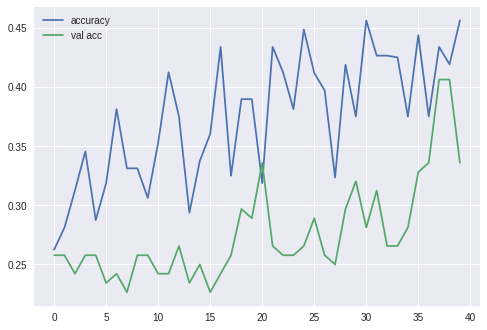

In [67]:
plt.style.use('seaborn')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(acc,label="accuracy")
plt.plot(val_acc,label="val acc")
plt.legend()
plt.show()

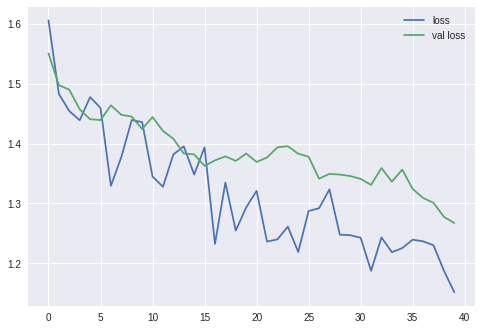

In [68]:
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val loss')
plt.legend()
plt.show()